## NLP with LSTM on Keras

- https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/

In [1]:
import numpy as np
import pylab as plt
import pandas as pd

import re
import string

from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import precision_recall_fscore_support as score

np.random.seed(7)

data_dir = './data/'

## Loading and preprocessing the data

- Load imdb data from keras.datasets
- Join the train and test (both equal) to make one big data
- Pad the data (Since different reviews have different length)
- split the data into train/test/val


In [2]:
email_data = pd.read_csv(data_dir+"spam.csv",encoding ='latin1')
print (email_data.columns)
email_data.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1, inplace=True)
email_data.rename(columns={"v1":"target", "v2":"email"}, inplace=True)
email_data['label'] = email_data['target'].apply(lambda x: int(x=='spam'))
email_data.head(3)

Index(['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], dtype='object')


,target,email,label
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1


### process the email text

- lower the email
- remove the stopwords
- Stemmize the words
- Tokenize the email whenever necessary


In [3]:

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

st =  PorterStemmer()

def process_email(email):
    #lower email
    email = email.lower()
    email = REPLACE_BY_SPACE_RE.sub(' ',email)
    email = BAD_SYMBOLS_RE.sub(' ', email)
    
    #remove stopwords and stemmize
    email=" ".join(st.stem(w) for w in email.split() if w not in STOPWORDS)
    return email

email_data['email_processed'] = email_data['email'].apply(process_email)
email_data.head(2)

,target,email,label,email_processed
0,ham,"Go until jurong point, crazy.. Available only ...",0,go jurong point crazi avail bugi n great world...
1,ham,Ok lar... Joking wif u oni...,0,ok lar joke wif u oni


In [4]:
def split_data(data):
    X_train_, X_test, y_train_, y_test = train_test_split(data['email_processed'].values, data['label'].values, test_size=0.2)
    X_train,  X_val, y_train, y_val = train_test_split(X_train_, y_train_, test_size=0.25)
    return X_train, X_val, X_test, y_train, y_val, y_test

X_train, X_val, X_test, y_train, y_val, y_test = split_data(email_data)

In [5]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [6]:
from tensorflow.keras.preprocessing.text import Tokenizer

MAX_SEQ_LEN = 300   # length of each email
MAX_WORDS   = 2000  # use only this many max used words

def prepare_data_for_model(X_train, X_val, X_test):
    tokenizer = Tokenizer(num_words=MAX_WORDS)
    tokenizer.fit_on_texts(X_train)
    X_train = tokenizer.texts_to_sequences(X_train)
    X_val   = tokenizer.texts_to_sequences(X_val)    
    X_test  = tokenizer.texts_to_sequences(X_test)
    
    X_train = pad_sequences(X_train, maxlen=MAX_SEQ_LEN)
    X_val   = pad_sequences(X_val,   maxlen=MAX_SEQ_LEN)
    X_test  = pad_sequences(X_test,  maxlen=MAX_SEQ_LEN)
    
    print (f"X_train.shape: {X_train.shape} y_train.shape:{y_train.shape}" )
    print (f"X_test.shape: {X_test.shape} y_test.shape:{y_test.shape}" )
    print (f"X_val.shape: {X_val.shape} y_val.shape:{y_val.shape}" )
    
    return (X_train, X_val, X_test, tokenizer)

    
(X_train, X_val, X_test, tokenizer) = prepare_data_for_model(X_train, X_val, X_test)

X_train.shape: (3342, 300) y_train.shape:(3342,)
X_test.shape: (1115, 300) y_test.shape:(1115,)
X_val.shape: (1115, 300) y_val.shape:(1115,)


In [7]:
word_index = tokenizer.word_index
len(word_index)

5569

## Model Building with LSTM

- First: Embedded layer that uses 32 length vectors to represent each word.
- Add LSTM with 100 neurons.
- Finally add a Dense layer with sigmoid activation as this is a binary classification problem ( Hence just a single neuron).


In [8]:

# Keras module
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, LSTM, Bidirectional
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPool1D, BatchNormalization
from keras.layers.embeddings import Embedding

In [9]:
def make_model(X, y, embedding_length = 16):
    model = Sequential()
    
    model.add(Embedding(MAX_WORDS, embedding_length, input_length=X.shape[1]))
    model.add(LSTM(16, activation='relu', return_sequences=True))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model1 = make_model(X_train, y_train)
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 16)           32000     
_________________________________________________________________
lstm (LSTM)                  (None, 300, 16)           2112      
_________________________________________________________________
dropout (Dropout)            (None, 300, 16)           0         
_________________________________________________________________
batch_normalization (BatchNo (None, 300, 16)           64        
_________________________________________________________________
flatten (Flatten)            (None, 4800)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 4801      
Total params: 38,977
Trainable params: 38,945
Non-trainable params: 32
___________________________________________________

In [10]:
history1 = model1.fit(X_train, y_train,
                    validation_data=(X_val, y_val), 
                    epochs=8,
                    batch_size=16,
                    verbose=1)

Epoch 1/8
209/209 [==============================] - 17s 80ms/step - loss: 0.2559 - accuracy: 0.9039 - val_loss: 0.3149 - val_accuracy: 0.8726
Epoch 2/8
209/209 [==============================] - 16s 76ms/step - loss: 0.0566 - accuracy: 0.9838 - val_loss: 0.1351 - val_accuracy: 0.9489
Epoch 3/8
209/209 [==============================] - 17s 81ms/step - loss: 0.0227 - accuracy: 0.9952 - val_loss: 0.0689 - val_accuracy: 0.9803
Epoch 4/8
209/209 [==============================] - 17s 79ms/step - loss: 0.0173 - accuracy: 0.9964 - val_loss: 0.0817 - val_accuracy: 0.9830
Epoch 5/8
209/209 [==============================] - 14s 69ms/step - loss: 0.0112 - accuracy: 0.9976 - val_loss: 0.0562 - val_accuracy: 0.9874
Epoch 6/8
209/209 [==============================] - 15s 70ms/step - loss: 0.0074 - accuracy: 0.9982 - val_loss: 0.0738 - val_accuracy: 0.9865
Epoch 7/8
209/209 [==============================] - 14s 69ms/step - loss: 0.0084 - accuracy: 0.9982 - val_loss: 0.0588 - val_accuracy: 0.9865

35/35 [==============================] - 0s 12ms/step - loss: 0.0791 - accuracy: 0.9848
Test accuracy: 98.48%


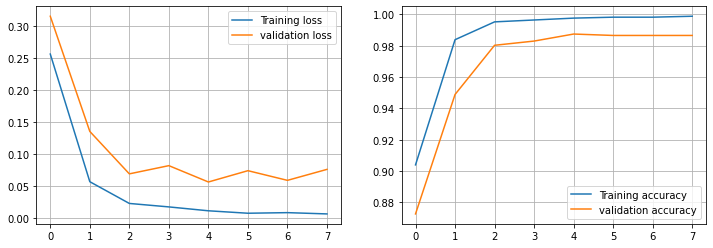

In [11]:
from helper import plot_history

score = model1.evaluate(X_test, y_test)
print("Test accuracy: %.2f%%" % (score[1]*100))
plot_history(history1)

In [12]:
def make_model_bidirectional(X, y, embedding_length = 16):
    model = Sequential()
    model.add(Embedding(MAX_WORDS, embedding_length, input_length=X.shape[1]))
    model.add(Bidirectional(LSTM(16, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)))
    model.add(Conv1D(16, kernel_size = 3, padding = "valid"))
    model.add(GlobalMaxPool1D())
    #model.add(Dense(16, activation='sigmoid'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model2 = make_model_bidirectional(X_train, y_train)
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 16)           32000     
_________________________________________________________________
bidirectional (Bidirectional (None, 300, 32)           4224      
_________________________________________________________________
conv1d (Conv1D)              (None, 298, 16)           1552      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 37,793
Trainable params: 37,793
Non-trainable params: 0
_________________________________________________________________


In [13]:
history2 = model2.fit(X_train, y_train,
                      validation_data=(X_val, y_val), 
                      epochs=8,
                      batch_size=16,
                      verbose=1)

Epoch 1/8
209/209 [==============================] - 59s 283ms/step - loss: 0.2551 - accuracy: 0.9105 - val_loss: 0.0504 - val_accuracy: 0.9830
Epoch 2/8
209/209 [==============================] - 58s 276ms/step - loss: 0.0378 - accuracy: 0.9889 - val_loss: 0.0395 - val_accuracy: 0.9910
Epoch 3/8
209/209 [==============================] - 59s 281ms/step - loss: 0.0199 - accuracy: 0.9952 - val_loss: 0.0405 - val_accuracy: 0.9901
Epoch 4/8
209/209 [==============================] - 58s 280ms/step - loss: 0.0116 - accuracy: 0.9973 - val_loss: 0.0424 - val_accuracy: 0.9883
Epoch 5/8
209/209 [==============================] - 58s 275ms/step - loss: 0.0079 - accuracy: 0.9985 - val_loss: 0.0484 - val_accuracy: 0.9865
Epoch 6/8
209/209 [==============================] - 58s 276ms/step - loss: 0.0064 - accuracy: 0.9985 - val_loss: 0.0540 - val_accuracy: 0.9865
Epoch 7/8
209/209 [==============================] - 58s 276ms/step - loss: 0.0039 - accuracy: 0.9988 - val_loss: 0.0571 - val_accuracy:

35/35 [==============================] - 1s 35ms/step - loss: 0.0651 - accuracy: 0.9848
Test accuracy: 98.48%


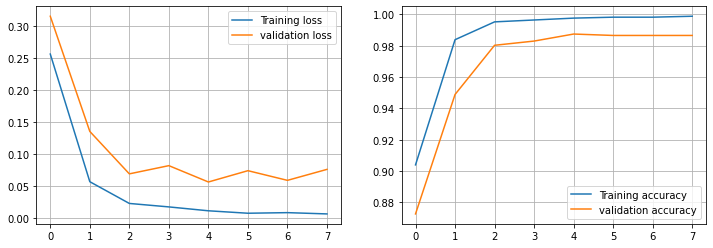

In [14]:
from helper import plot_history

score = model2.evaluate(X_test, y_test)
print("Test accuracy: %.2f%%" % (score[1]*100))
plot_history(history1)

In [15]:
y_pred_blstm=model2.predict(X_test)

precision, recall, fscore, support = score(y_test, y_pred_blstm.round())
print('precision: {}'.format(precision))
print('recall: {}'.format(recall)) 
print('fscore: {}'.format(fscore)) 
print('support: {}'.format(support))
print("############################")
print(classification_report(y_test, y_pred_blstm.round()))

precision: [0.98672114 0.97058824]
recall: [0.99587629 0.91034483]
fscore: [0.99127758 0.93950178]
support: [970 145]
############################
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       970
           1       0.97      0.91      0.94       145

    accuracy                           0.98      1115
   macro avg       0.98      0.95      0.97      1115
weighted avg       0.98      0.98      0.98      1115

